In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import RFE, SelectKBest, f_classif
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 1. Load Morphological Feature Dataset

In [2]:
# Load the dataset with morphological features
df = pd.read_csv('../train/arb_clean_basic_morphological.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['polarization'].value_counts())
print(f"\nClass balance: {df['polarization'].value_counts(normalize=True)}")
df.head()

Dataset shape: (3380, 28)

Columns: ['id', 'text', 'polarization', 'morph_num_tokens', 'morph_num_nouns', 'morph_num_verbs', 'morph_num_adjectives', 'morph_num_adverbs', 'morph_num_pronouns', 'morph_num_prepositions', 'morph_num_conjunctions', 'morph_num_particles', 'morph_num_proclitics', 'morph_num_enclitics', 'morph_avg_word_length', 'morph_ratio_nouns', 'morph_ratio_verbs', 'morph_ratio_adjectives', 'morph_unique_lemmas', 'morph_unique_roots', 'morph_num_masculine', 'morph_num_feminine', 'morph_num_singular', 'morph_num_dual', 'morph_num_plural', 'morph_num_perfective', 'morph_num_imperfective', 'morph_num_imperative']

Class distribution:
polarization
0    1868
1    1512
Name: count, dtype: int64

Class balance: polarization
0    0.552663
1    0.447337
Name: proportion, dtype: float64


,id,text,polarization,morph_num_tokens,morph_num_nouns,morph_num_verbs,morph_num_adjectives,morph_num_adverbs,morph_num_pronouns,morph_num_prepositions,...,morph_unique_lemmas,morph_unique_roots,morph_num_masculine,morph_num_feminine,morph_num_singular,morph_num_dual,morph_num_plural,morph_num_perfective,morph_num_imperfective,morph_num_imperative
0,arb_a2a60c8b4af3389e842d8ec31afb0eea,احلام انتي ونعالي ومنو انتي حتي تقيمين الفناني...,1,18,13,1,0,0,0,1,...,11,10,9,5,7,3,4,0,1,0
1,arb_6723e56a672674a6c1d9b28b213c4a05,وره الكواليس تنيجج من وره بعير صطناعي علي فكرة...,1,19,7,1,0,0,0,4,...,12,12,4,4,5,0,3,1,0,0
2,arb_b0365d606edeee38ae6c025b1ca33e96,.خخخخ الملكه احلام فيها شذوذ شنو هل بوس والدلع...,1,20,10,2,0,0,0,2,...,14,14,9,3,9,0,3,2,0,0
3,arb_858c0ee684049ba6f416a6cecb0b0761,الله يخزي احلام هي والبرنامج الخايس الي كله مصخره,1,9,3,2,0,0,1,1,...,7,7,5,1,5,0,1,0,1,1
4,arb_bdafc73afd0bc2cd2badae2a089446b9,كس ام احلام الي ماربتها وش ملكه هههه متستاهل م...,1,22,8,4,1,0,0,1,...,14,15,11,1,11,0,1,3,1,0


## 2. Feature Analysis & Correlation

In [3]:
# Get morphological feature columns
morph_features = [col for col in df.columns if col.startswith('morph_')]
print(f"Number of morphological features: {len(morph_features)}")
print(f"\nFeatures: {morph_features}")

# Basic statistics
print("\n" + "="*80)
print("Feature Statistics:")
print("="*80)
df[morph_features].describe()

Number of morphological features: 25

Features: ['morph_num_tokens', 'morph_num_nouns', 'morph_num_verbs', 'morph_num_adjectives', 'morph_num_adverbs', 'morph_num_pronouns', 'morph_num_prepositions', 'morph_num_conjunctions', 'morph_num_particles', 'morph_num_proclitics', 'morph_num_enclitics', 'morph_avg_word_length', 'morph_ratio_nouns', 'morph_ratio_verbs', 'morph_ratio_adjectives', 'morph_unique_lemmas', 'morph_unique_roots', 'morph_num_masculine', 'morph_num_feminine', 'morph_num_singular', 'morph_num_dual', 'morph_num_plural', 'morph_num_perfective', 'morph_num_imperfective', 'morph_num_imperative']

Feature Statistics:


,morph_num_tokens,morph_num_nouns,morph_num_verbs,morph_num_adjectives,morph_num_adverbs,morph_num_pronouns,morph_num_prepositions,morph_num_conjunctions,morph_num_particles,morph_num_proclitics,...,morph_unique_lemmas,morph_unique_roots,morph_num_masculine,morph_num_feminine,morph_num_singular,morph_num_dual,morph_num_plural,morph_num_perfective,morph_num_imperfective,morph_num_imperative
count,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,...,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000
mean,18.344083,7.811834,2.492308,1.414201,0.078994,0.458580,1.458284,0.610059,0.299112,16.695562,...,14.578402,13.635207,9.423077,2.732544,9.818639,0.583136,1.764201,0.998817,1.379586,0.108876
std,8.933493,4.159029,1.996208,1.400558,0.309612,0.814053,1.385581,1.049254,0.636885,8.516331,...,6.634682,5.938503,4.906676,2.291447,5.149204,0.879486,1.695097,1.215466,1.360891,0.355040
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,...,10.000000,9.000000,6.000000,1.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,17.000000,7.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,15.000000,...,14.000000,13.000000,8.000000,2.000000,9.000000,0.000000,1.000000,1.000000,1.000000,0.000000
75%,22.000000,10.000000,3.000000,2.000000,0.000000,1.000000,2.000000,1.000000,0.000000,21.000000,...,18.000000,17.000000,12.000000,4.000000,12.000000,1.000000,3.000000,2.000000,2.000000,0.000000
max,91.000000,42.000000,15.000000,11.000000,4.000000,7.000000,11.000000,9.000000,6.000000,80.000000,...,60.000000,51.000000,47.000000,18.000000,56.000000,7.000000,12.000000,10.000000,9.000000,3.000000


Top 10 Most Positively Correlated Features with Toxicity:
morph_ratio_verbs         0.170361
morph_num_verbs           0.169819
morph_num_perfective      0.139438
morph_num_conjunctions    0.123413
morph_num_particles       0.110020
morph_num_imperfective    0.101482
morph_num_masculine       0.097067
morph_num_pronouns        0.092571
morph_num_imperative      0.079418
morph_num_plural          0.077423
dtype: float64

Top 10 Most Negatively Correlated Features with Toxicity:
morph_num_enclitics       0.037617
morph_num_proclitics      0.037617
morph_unique_lemmas       0.025963
morph_num_nouns           0.020534
morph_avg_word_length     0.014344
morph_num_prepositions   -0.005122
morph_num_feminine       -0.022233
morph_num_adjectives     -0.051530
morph_ratio_nouns        -0.065630
morph_ratio_adjectives   -0.112646
dtype: float64


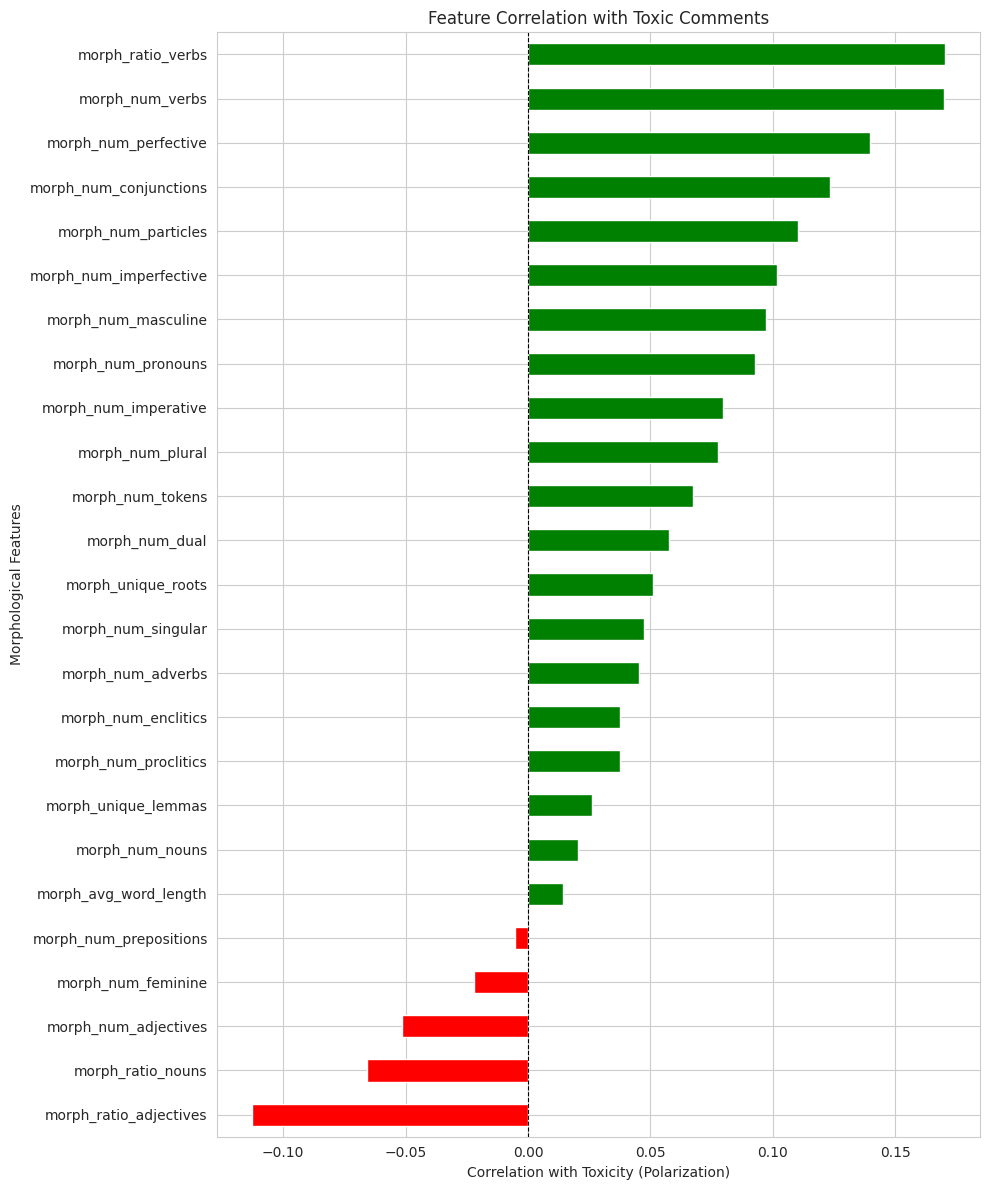

In [4]:
# Correlation with target
correlations = df[morph_features].corrwith(df['polarization']).sort_values(ascending=False)

print("Top 10 Most Positively Correlated Features with Toxicity:")
print(correlations.head(10))
print("\nTop 10 Most Negatively Correlated Features with Toxicity:")
print(correlations.tail(10))

# Visualize
plt.figure(figsize=(10, 12))
correlations.sort_values().plot(kind='barh', color=['red' if x < 0 else 'green' for x in correlations.sort_values()])
plt.xlabel('Correlation with Toxicity (Polarization)')
plt.ylabel('Morphological Features')
plt.title('Feature Correlation with Toxic Comments')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

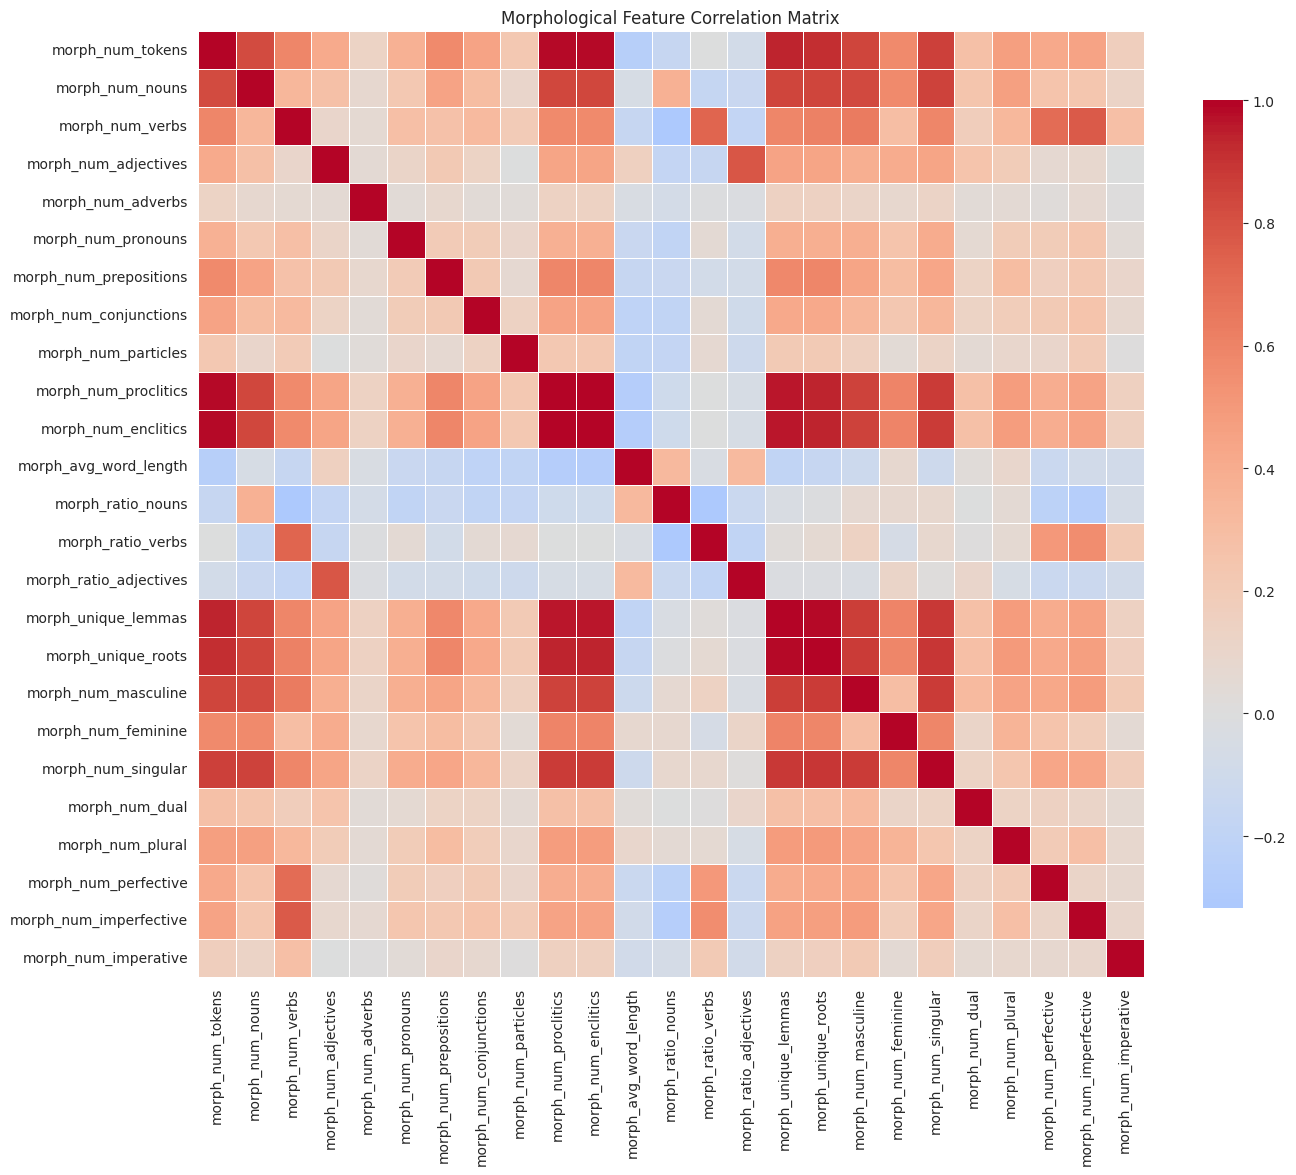


Highly correlated feature pairs (|r| > 0.8):
  morph_num_tokens <-> morph_num_nouns: 0.824
  morph_num_tokens <-> morph_num_proclitics: 0.982
  morph_num_tokens <-> morph_num_enclitics: 0.982
  morph_num_tokens <-> morph_unique_lemmas: 0.937
  morph_num_tokens <-> morph_unique_roots: 0.916
  morph_num_tokens <-> morph_num_masculine: 0.846
  morph_num_tokens <-> morph_num_singular: 0.858
  morph_num_nouns <-> morph_num_proclitics: 0.837
  morph_num_nouns <-> morph_num_enclitics: 0.837
  morph_num_nouns <-> morph_unique_lemmas: 0.848
  morph_num_nouns <-> morph_unique_roots: 0.846
  morph_num_nouns <-> morph_num_masculine: 0.832
  morph_num_nouns <-> morph_num_singular: 0.852
  morph_num_proclitics <-> morph_num_enclitics: 1.000
  morph_num_proclitics <-> morph_unique_lemmas: 0.959
  morph_num_proclitics <-> morph_unique_roots: 0.935
  morph_num_proclitics <-> morph_num_masculine: 0.852
  morph_num_proclitics <-> morph_num_singular: 0.872
  morph_num_enclitics <-> morph_unique_lemmas: 0

In [5]:
# Feature correlation heatmap (check for multicollinearity)
plt.figure(figsize=(14, 12))
corr_matrix = df[morph_features].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Morphological Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Identify highly correlated features
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print("\nHighly correlated feature pairs (|r| > 0.8):")
    for f1, f2, corr in high_corr_pairs:
        print(f"  {f1} <-> {f2}: {corr:.3f}")
else:
    print("\nNo highly correlated feature pairs found (good!)")

## 3. Data Preparation

In [6]:
# Prepare features and target
X = df[morph_features].values
y = df['polarization'].values

# Split data: 90% train, 10% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTraining set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data prepared and scaled")

Training set size: 3042 (90.0%)
Test set size: 338 (10.0%)

Training set class distribution: [1681 1361]
Test set class distribution: [187 151]

✓ Data prepared and scaled


## 4. Model Training & Evaluation

### 4.1 Logistic Regression

Training Logistic Regression...

LOGISTIC REGRESSION RESULTS
Accuracy: 0.6864
F1-Score: 0.6370
Precision: 0.6596
Recall: 0.6159

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.71      0.74      0.72       187
       Toxic       0.66      0.62      0.64       151

    accuracy                           0.69       338
   macro avg       0.68      0.68      0.68       338
weighted avg       0.69      0.69      0.69       338



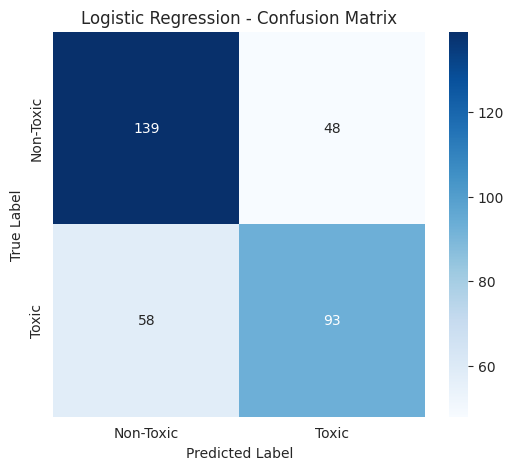


Top 10 Most Important Features (by absolute coefficient):
                   feature  coefficient
0         morph_num_tokens     1.312270
15     morph_unique_lemmas    -1.181637
9     morph_num_proclitics    -0.675276
10     morph_num_enclitics    -0.675276
2          morph_num_verbs     0.640528
16      morph_unique_roots     0.450724
23  morph_num_imperfective    -0.372096
3     morph_num_adjectives     0.348228
7   morph_num_conjunctions     0.299392
1          morph_num_nouns     0.296103


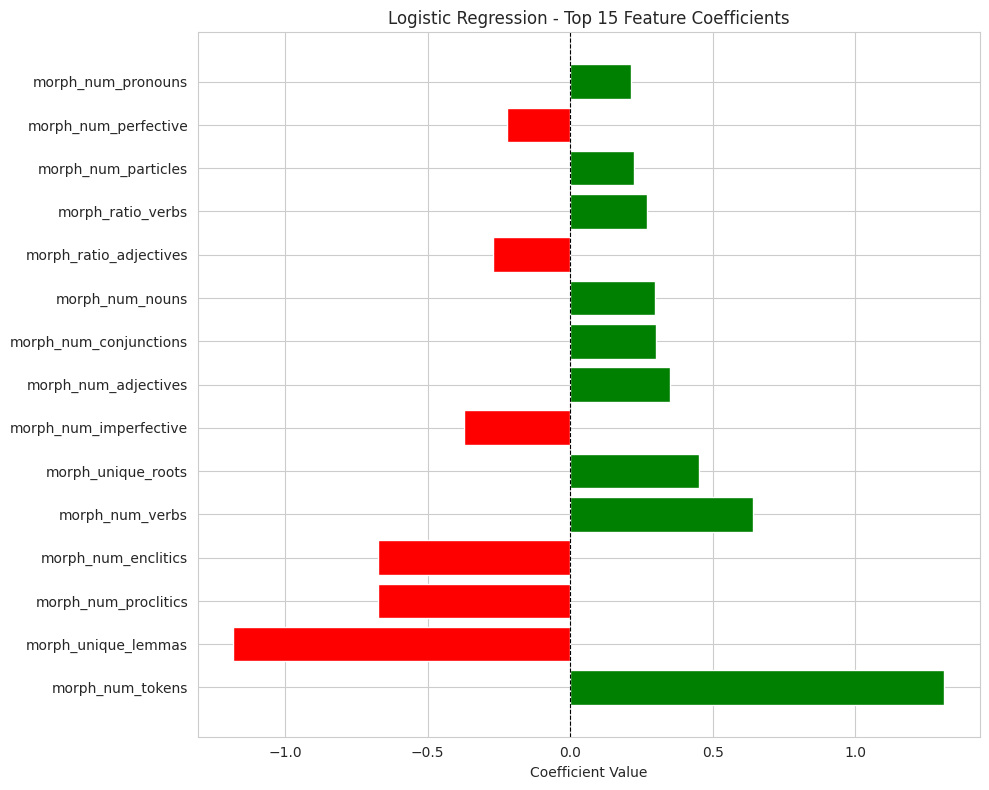

In [7]:
# Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)

# Evaluation
print("\n" + "="*80)
print("LOGISTIC REGRESSION RESULTS")
print("="*80)
print(f"Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, lr_pred):.4f}")
print(f"Precision: {precision_score(y_test, lr_pred):.4f}")
print(f"Recall: {recall_score(y_test, lr_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred, target_names=['Non-Toxic', 'Toxic']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'])
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance (coefficients)
lr_importance = pd.DataFrame({
    'feature': morph_features,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features (by absolute coefficient):")
print(lr_importance.head(10))

plt.figure(figsize=(10, 8))
top_features = lr_importance.head(15)
colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression - Top 15 Feature Coefficients')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

### 4.2 Random Forest

Training Random Forest...

RANDOM FOREST RESULTS
Accuracy: 0.6509
F1-Score: 0.6144
Precision: 0.6065
Recall: 0.6225

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.69      0.67      0.68       187
       Toxic       0.61      0.62      0.61       151

    accuracy                           0.65       338
   macro avg       0.65      0.65      0.65       338
weighted avg       0.65      0.65      0.65       338



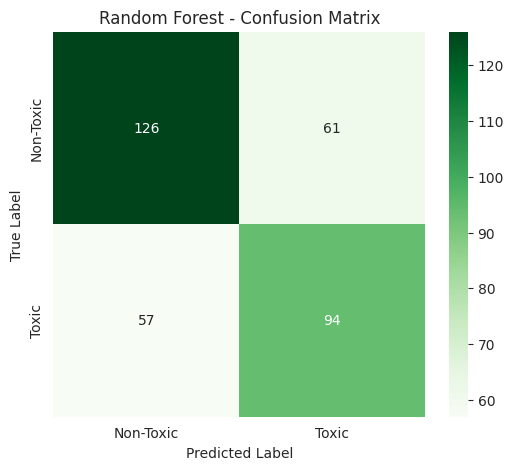


Top 10 Most Important Features:
                   feature  importance
11   morph_avg_word_length    0.082109
13       morph_ratio_verbs    0.071510
12       morph_ratio_nouns    0.062443
17     morph_num_masculine    0.058131
2          morph_num_verbs    0.057702
14  morph_ratio_adjectives    0.052613
0         morph_num_tokens    0.051590
7   morph_num_conjunctions    0.050118
15     morph_unique_lemmas    0.048923
19      morph_num_singular    0.044617


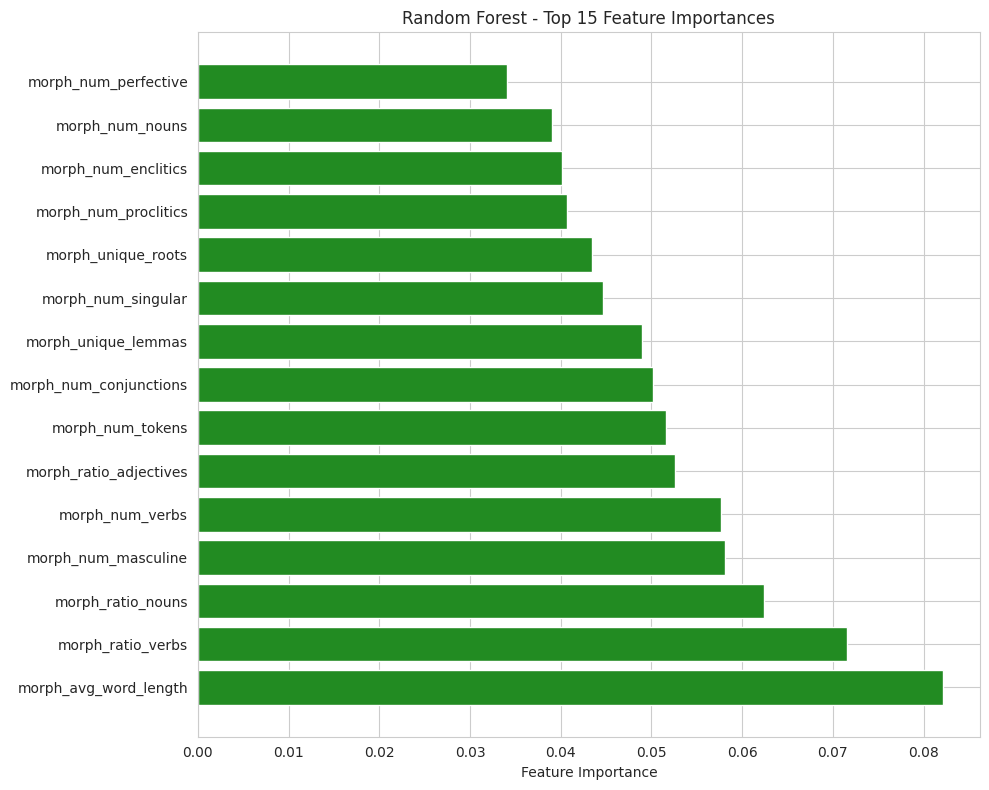

In [8]:
# Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)

# Evaluation
print("\n" + "="*80)
print("RANDOM FOREST RESULTS")
print("="*80)
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, rf_pred):.4f}")
print(f"Precision: {precision_score(y_test, rf_pred):.4f}")
print(f"Recall: {recall_score(y_test, rf_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=['Non-Toxic', 'Toxic']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'])
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance
rf_importance = pd.DataFrame({
    'feature': morph_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(rf_importance.head(10))

plt.figure(figsize=(10, 8))
top_features = rf_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='forestgreen')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest - Top 15 Feature Importances')
plt.tight_layout()
plt.show()

### 4.3 XGBoost

Training XGBoost...

XGBOOST RESULTS
Accuracy: 0.6716
F1-Score: 0.6498
Precision: 0.6205
Recall: 0.6821

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.72      0.66      0.69       187
       Toxic       0.62      0.68      0.65       151

    accuracy                           0.67       338
   macro avg       0.67      0.67      0.67       338
weighted avg       0.68      0.67      0.67       338



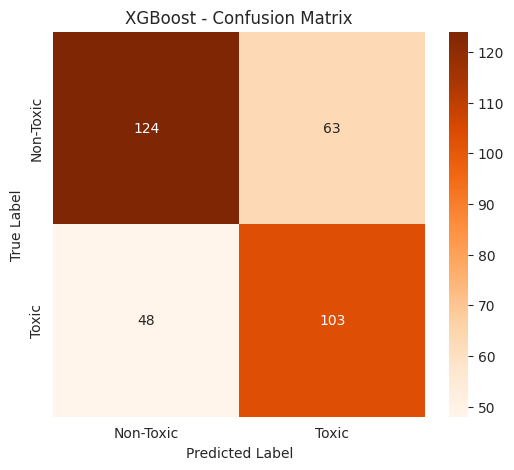


Top 10 Most Important Features:
                   feature  importance
2          morph_num_verbs    0.132321
7   morph_num_conjunctions    0.071383
24    morph_num_imperative    0.059188
22    morph_num_perfective    0.045339
17     morph_num_masculine    0.044041
15     morph_unique_lemmas    0.043502
8      morph_num_particles    0.041069
0         morph_num_tokens    0.041059
5       morph_num_pronouns    0.040688
11   morph_avg_word_length    0.036668


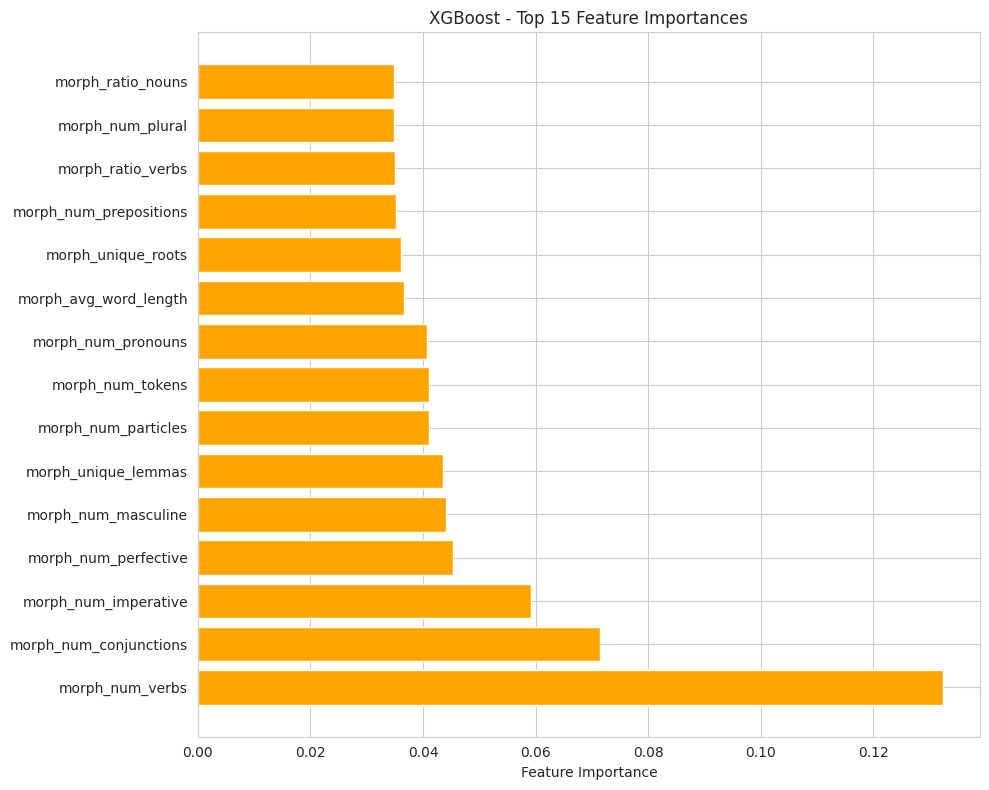

In [9]:
# XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)

# Evaluation
print("\n" + "="*80)
print("XGBOOST RESULTS")
print("="*80)
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, xgb_pred):.4f}")
print(f"Precision: {precision_score(y_test, xgb_pred):.4f}")
print(f"Recall: {recall_score(y_test, xgb_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred, target_names=['Non-Toxic', 'Toxic']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'])
plt.title('XGBoost - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance
xgb_importance = pd.DataFrame({
    'feature': morph_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(xgb_importance.head(10))

plt.figure(figsize=(10, 8))
top_features = xgb_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='orange')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost - Top 15 Feature Importances')
plt.tight_layout()
plt.show()

### 4.4 LightGBM

Training LightGBM...

LIGHTGBM RESULTS
Accuracy: 0.6361
F1-Score: 0.5967
Precision: 0.5909
Recall: 0.6026

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.67      0.66      0.67       187
       Toxic       0.59      0.60      0.60       151

    accuracy                           0.64       338
   macro avg       0.63      0.63      0.63       338
weighted avg       0.64      0.64      0.64       338



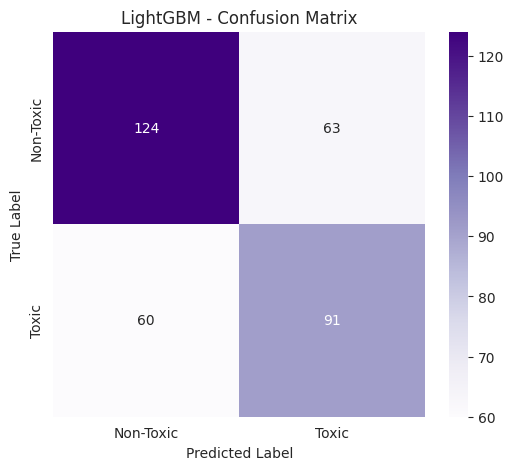


Top 10 Most Important Features:
                   feature  importance
11   morph_avg_word_length         580
12       morph_ratio_nouns         471
13       morph_ratio_verbs         329
14  morph_ratio_adjectives         272
15     morph_unique_lemmas         258
0         morph_num_tokens         218
17     morph_num_masculine         195
9     morph_num_proclitics         194
19      morph_num_singular         194
16      morph_unique_roots         162


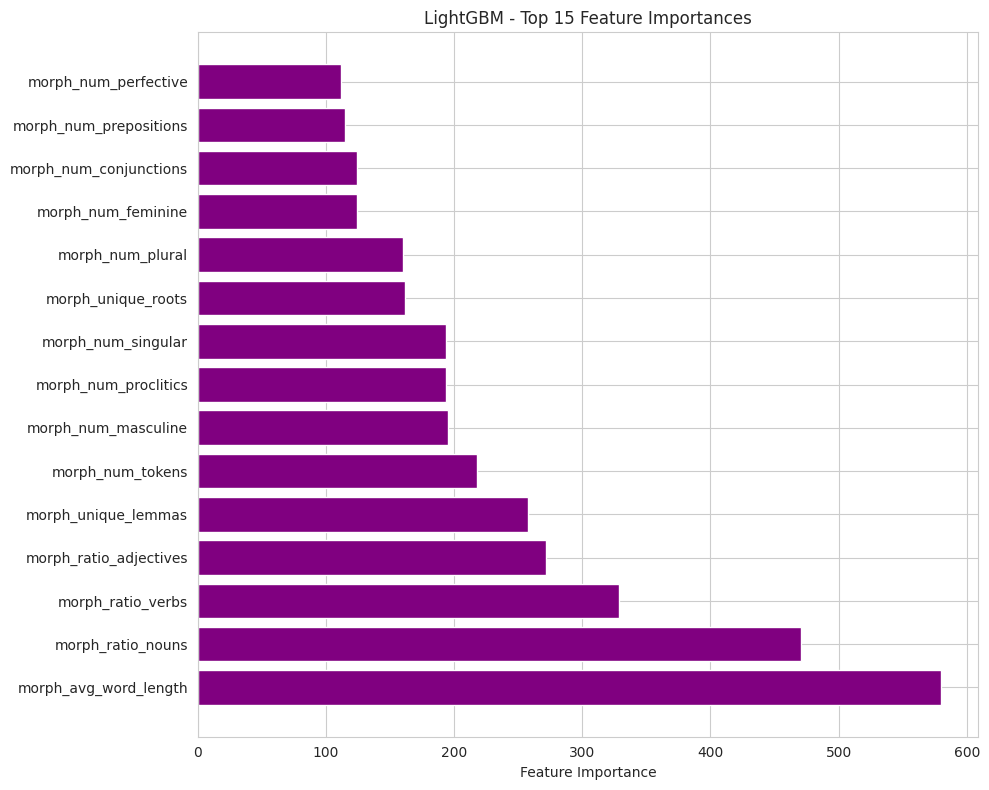

In [10]:
# LightGBM
print("Training LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbosity=-1
)
lgb_model.fit(X_train, y_train)

# Predictions
lgb_pred = lgb_model.predict(X_test)
lgb_pred_proba = lgb_model.predict_proba(X_test)

# Evaluation
print("\n" + "="*80)
print("LIGHTGBM RESULTS")
print("="*80)
print(f"Accuracy: {accuracy_score(y_test, lgb_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, lgb_pred):.4f}")
print(f"Precision: {precision_score(y_test, lgb_pred):.4f}")
print(f"Recall: {recall_score(y_test, lgb_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lgb_pred, target_names=['Non-Toxic', 'Toxic']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, lgb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'])
plt.title('LightGBM - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance
lgb_importance = pd.DataFrame({
    'feature': morph_features,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(lgb_importance.head(10))

plt.figure(figsize=(10, 8))
top_features = lgb_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='purple')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('LightGBM - Top 15 Feature Importances')
plt.tight_layout()
plt.show()

### 4.5 SVM (RBF Kernel)

Training SVM (RBF kernel)...

SVM (RBF) RESULTS
Accuracy: 0.6627
F1-Score: 0.6415
Precision: 0.6108
Recall: 0.6755

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.71      0.65      0.68       187
       Toxic       0.61      0.68      0.64       151

    accuracy                           0.66       338
   macro avg       0.66      0.66      0.66       338
weighted avg       0.67      0.66      0.66       338



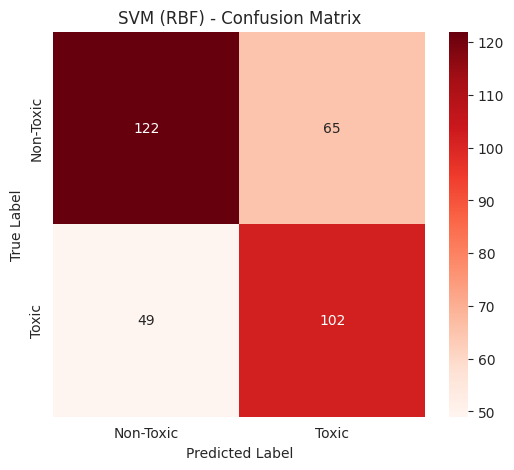

In [11]:
# SVM with RBF kernel
print("Training SVM (RBF kernel)...")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predictions
svm_pred = svm_model.predict(X_test_scaled)
svm_pred_proba = svm_model.predict_proba(X_test_scaled)

# Evaluation
print("\n" + "="*80)
print("SVM (RBF) RESULTS")
print("="*80)
print(f"Accuracy: {accuracy_score(y_test, svm_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, svm_pred):.4f}")
print(f"Precision: {precision_score(y_test, svm_pred):.4f}")
print(f"Recall: {recall_score(y_test, svm_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_pred, target_names=['Non-Toxic', 'Toxic']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'])
plt.title('SVM (RBF) - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 5. Model Comparison


MODEL COMPARISON
              Model  Accuracy  F1-Score  Precision   Recall
            XGBoost  0.671598  0.649842   0.620482 0.682119
          SVM (RBF)  0.662722  0.641509   0.610778 0.675497
Logistic Regression  0.686391  0.636986   0.659574 0.615894
      Random Forest  0.650888  0.614379   0.606452 0.622517
           LightGBM  0.636095  0.596721   0.590909 0.602649


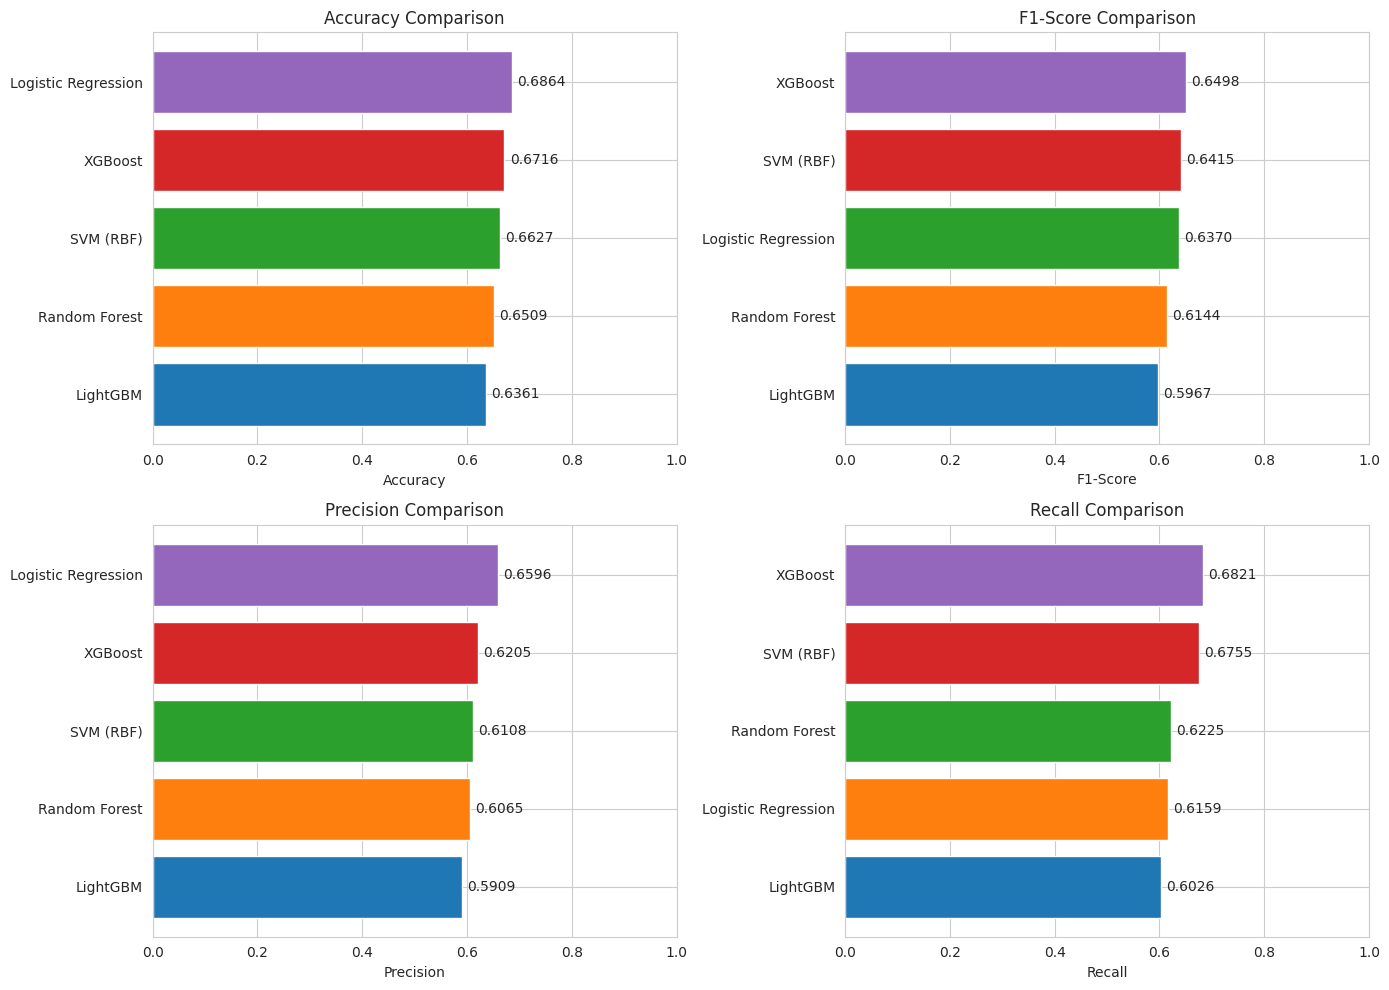

In [12]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'SVM (RBF)'],
    'Accuracy': [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, xgb_pred),
        accuracy_score(y_test, lgb_pred),
        accuracy_score(y_test, svm_pred)
    ],
    'F1-Score': [
        f1_score(y_test, lr_pred),
        f1_score(y_test, rf_pred),
        f1_score(y_test, xgb_pred),
        f1_score(y_test, lgb_pred),
        f1_score(y_test, svm_pred)
    ],
    'Precision': [
        precision_score(y_test, lr_pred),
        precision_score(y_test, rf_pred),
        precision_score(y_test, xgb_pred),
        precision_score(y_test, lgb_pred),
        precision_score(y_test, svm_pred)
    ],
    'Recall': [
        recall_score(y_test, lr_pred),
        recall_score(y_test, rf_pred),
        recall_score(y_test, xgb_pred),
        recall_score(y_test, lgb_pred),
        recall_score(y_test, svm_pred)
    ]
}).sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(results.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    sorted_results = results.sort_values(metric, ascending=True)
    ax.barh(sorted_results['Model'], sorted_results[metric], color=colors)
    ax.set_xlabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xlim([0, 1])
    
    # Add value labels
    for i, v in enumerate(sorted_results[metric]):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

## 6. Feature Importance Consensus

Combining feature importance from different models to identify the most important morphological features.

In [ ]:
# Combine feature importances from tree-based models
importance_df = pd.DataFrame({
    'feature': morph_features,
    'RF_importance': rf_model.feature_importances_,
    'XGB_importance': xgb_model.feature_importances_,
    'LGB_importance': lgb_model.feature_importances_,
    'LR_abs_coef': np.abs(lr_model.coef_[0])
})

In [14]:
importance_df.head()

,feature,RF_importance,XGB_importance,LGB_importance,LR_abs_coef
0,morph_num_tokens,0.051590,0.041059,218,1.312270
1,morph_num_nouns,0.039013,0.033309,106,0.296103
2,morph_num_verbs,0.057702,0.132321,74,0.640528
3,morph_num_adjectives,0.023529,0.025642,57,0.348228
4,morph_num_adverbs,0.006272,0.025165,30,0.135290


## 7. Ensemble Models

### 7.1 Voting Classifier

Training Voting Classifier...

VOTING CLASSIFIER RESULTS
Accuracy: 0.6953
F1-Score: 0.6688
Precision: 0.6500
Recall: 0.6887

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.74      0.70      0.72       187
       Toxic       0.65      0.69      0.67       151

    accuracy                           0.70       338
   macro avg       0.69      0.69      0.69       338
weighted avg       0.70      0.70      0.70       338



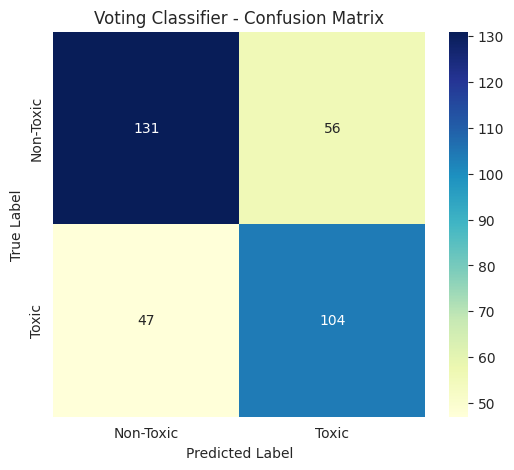

In [15]:
# Voting Classifier (soft voting - uses probabilities)
print("Training Voting Classifier...")

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
        ('xgb', xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='logloss')),
        ('lgb', lgb.LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, verbosity=-1))
    ],
    voting='soft'
)

voting_clf.fit(X_train_scaled, y_train)
voting_pred = voting_clf.predict(X_test_scaled)

print("\n" + "="*80)
print("VOTING CLASSIFIER RESULTS")
print("="*80)
print(f"Accuracy: {accuracy_score(y_test, voting_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, voting_pred):.4f}")
print(f"Precision: {precision_score(y_test, voting_pred):.4f}")
print(f"Recall: {recall_score(y_test, voting_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, voting_pred, target_names=['Non-Toxic', 'Toxic']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, voting_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'])
plt.title('Voting Classifier - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### 7.2 Stacking Classifier

Training Stacking Classifier...

STACKING CLASSIFIER RESULTS
Accuracy: 0.6420
F1-Score: 0.6134
Precision: 0.5926
Recall: 0.6358

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.69      0.65      0.67       187
       Toxic       0.59      0.64      0.61       151

    accuracy                           0.64       338
   macro avg       0.64      0.64      0.64       338
weighted avg       0.65      0.64      0.64       338



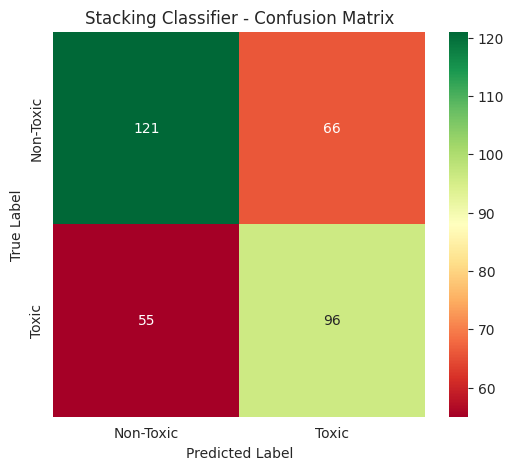

In [16]:
# Stacking Classifier
print("Training Stacking Classifier...")

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
        ('xgb', xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='logloss')),
        ('lgb', lgb.LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, verbosity=-1))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)

print("\n" + "="*80)
print("STACKING CLASSIFIER RESULTS")
print("="*80)
print(f"Accuracy: {accuracy_score(y_test, stacking_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, stacking_pred):.4f}")
print(f"Precision: {precision_score(y_test, stacking_pred):.4f}")
print(f"Recall: {recall_score(y_test, stacking_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, stacking_pred, target_names=['Non-Toxic', 'Toxic']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, stacking_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', 
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'])
plt.title('Stacking Classifier - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 8. Final Comparison with Ensemble Models


FINAL MODEL COMPARISON (Including Ensembles)
              Model  Accuracy  F1-Score  Precision   Recall
    Voting Ensemble  0.695266  0.668810   0.650000 0.688742
            XGBoost  0.671598  0.649842   0.620482 0.682119
          SVM (RBF)  0.662722  0.641509   0.610778 0.675497
Logistic Regression  0.686391  0.636986   0.659574 0.615894
      Random Forest  0.650888  0.614379   0.606452 0.622517
  Stacking Ensemble  0.642012  0.613419   0.592593 0.635762
           LightGBM  0.636095  0.596721   0.590909 0.602649

🏆 BEST MODEL: Voting Ensemble with F1-Score: 0.6688


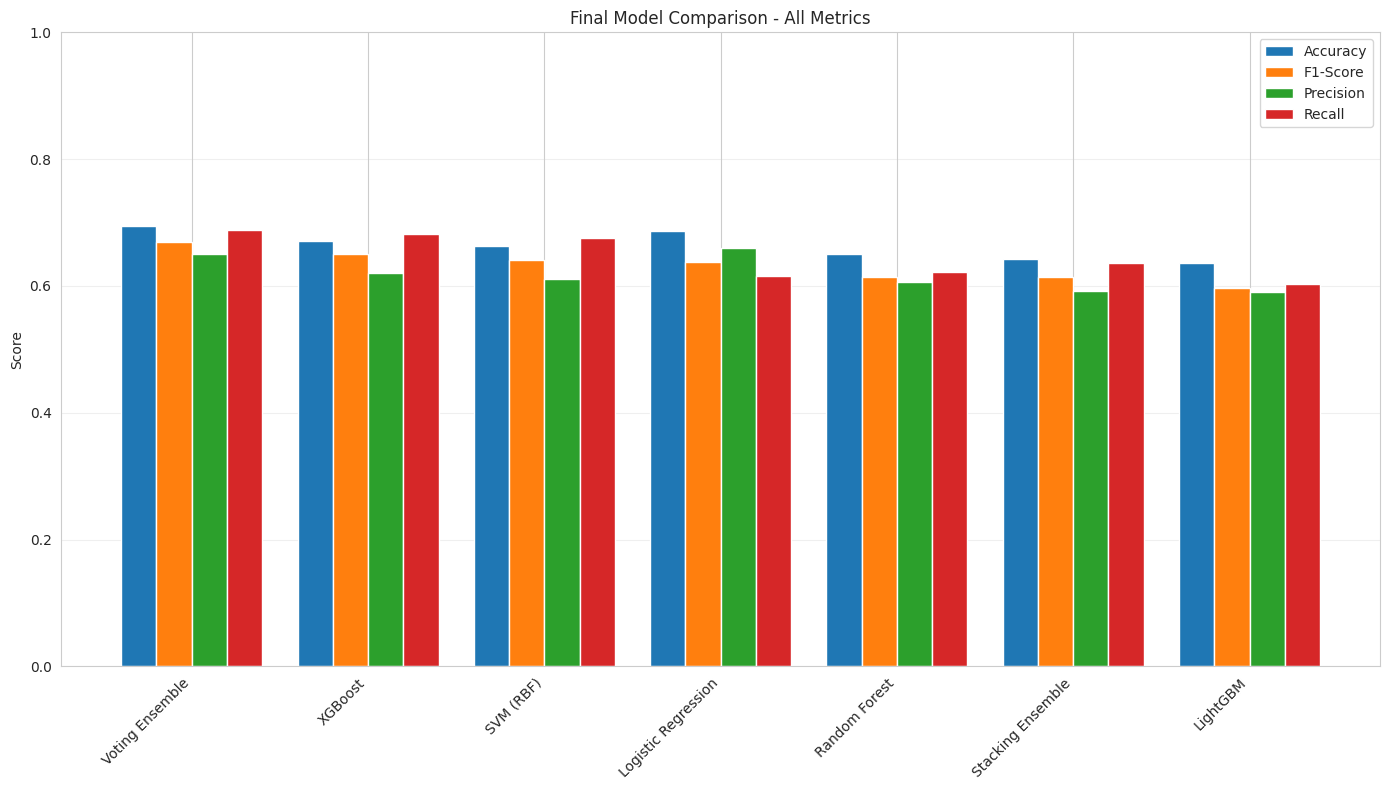

In [17]:
# Final comparison including ensemble models
final_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'SVM (RBF)', 'Voting Ensemble', 'Stacking Ensemble'],
    'Accuracy': [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, xgb_pred),
        accuracy_score(y_test, lgb_pred),
        accuracy_score(y_test, svm_pred),
        accuracy_score(y_test, voting_pred),
        accuracy_score(y_test, stacking_pred)
    ],
    'F1-Score': [
        f1_score(y_test, lr_pred),
        f1_score(y_test, rf_pred),
        f1_score(y_test, xgb_pred),
        f1_score(y_test, lgb_pred),
        f1_score(y_test, svm_pred),
        f1_score(y_test, voting_pred),
        f1_score(y_test, stacking_pred)
    ],
    'Precision': [
        precision_score(y_test, lr_pred),
        precision_score(y_test, rf_pred),
        precision_score(y_test, xgb_pred),
        precision_score(y_test, lgb_pred),
        precision_score(y_test, svm_pred),
        precision_score(y_test, voting_pred),
        precision_score(y_test, stacking_pred)
    ],
    'Recall': [
        recall_score(y_test, lr_pred),
        recall_score(y_test, rf_pred),
        recall_score(y_test, xgb_pred),
        recall_score(y_test, lgb_pred),
        recall_score(y_test, svm_pred),
        recall_score(y_test, voting_pred),
        recall_score(y_test, stacking_pred)
    ]
}).sort_values('F1-Score', ascending=False)

print("\n" + "="*100)
print("FINAL MODEL COMPARISON (Including Ensembles)")
print("="*100)
print(final_results.to_string(index=False))

# Highlight best model
best_model = final_results.iloc[0]['Model']
best_f1 = final_results.iloc[0]['F1-Score']
print(f"\n🏆 BEST MODEL: {best_model} with F1-Score: {best_f1:.4f}")

# Visualize final comparison
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(final_results))
width = 0.2

ax.bar(x - 1.5*width, final_results['Accuracy'], width, label='Accuracy', color='#1f77b4')
ax.bar(x - 0.5*width, final_results['F1-Score'], width, label='F1-Score', color='#ff7f0e')
ax.bar(x + 0.5*width, final_results['Precision'], width, label='Precision', color='#2ca02c')
ax.bar(x + 1.5*width, final_results['Recall'], width, label='Recall', color='#d62728')

ax.set_ylabel('Score')
ax.set_title('Final Model Comparison - All Metrics')
ax.set_xticks(x)
ax.set_xticklabels(final_results['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Key Insights & Summary

In [19]:
print("\n" + "="*100)
print("KEY INSIGHTS FROM MORPHOLOGICAL FEATURE-BASED CLASSIFICATION")
print("="*100)

print("\n1. MODEL PERFORMANCE:")
print(f"   Best performing model: {best_model}")
print(f"   Best F1-Score: {best_f1:.4f}")
print(f"   Number of features used: {len(morph_features)}")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")

# print("\n2. TOP 5 MOST IMPORTANT MORPHOLOGICAL FEATURES:")
# for idx, row in importance_df.head(5).iterrows():
#     print(f"   {row['feature']}: {row['avg_importance']:.4f}")

print("\n3. FEATURE INSIGHTS:")
top_feature = importance_df.iloc[0]['feature']
print(f"   Most important feature: {top_feature}")
print(f"   This suggests that {top_feature.replace('morph_', '').replace('_', ' ')} is a strong")
print(f"   indicator for distinguishing toxic from non-toxic comments in Arabic text.")

print("\n4. MODEL COMPARISON:")
tree_models = final_results[final_results['Model'].isin(['Random Forest', 'XGBoost', 'LightGBM'])]
linear_models = final_results[final_results['Model'].isin(['Logistic Regression', 'SVM (RBF)'])]
ensemble_models = final_results[final_results['Model'].isin(['Voting Ensemble', 'Stacking Ensemble'])]

print(f"   Average F1 (Tree-based): {tree_models['F1-Score'].mean():.4f}")
print(f"   Average F1 (Linear/SVM): {linear_models['F1-Score'].mean():.4f}")
print(f"   Average F1 (Ensembles): {ensemble_models['F1-Score'].mean():.4f}")

print("\n5. RECOMMENDATIONS:")
print("   - Morphological features alone provide reasonable classification performance")
print("   - Consider combining with text-based features (TF-IDF, embeddings) for better results")
print("   - The most important morphological patterns can help understand toxicity linguistics")
print("   - Ensemble methods provide marginal improvements over single models")
print("\n" + "="*100)


KEY INSIGHTS FROM MORPHOLOGICAL FEATURE-BASED CLASSIFICATION

1. MODEL PERFORMANCE:
   Best performing model: Voting Ensemble
   Best F1-Score: 0.6688
   Number of features used: 25
   Training samples: 3042
   Test samples: 338

3. FEATURE INSIGHTS:
   Most important feature: morph_num_tokens
   This suggests that num tokens is a strong
   indicator for distinguishing toxic from non-toxic comments in Arabic text.

4. MODEL COMPARISON:
   Average F1 (Tree-based): 0.6203
   Average F1 (Linear/SVM): 0.6392
   Average F1 (Ensembles): 0.6411

5. RECOMMENDATIONS:
   - Morphological features alone provide reasonable classification performance
   - Consider combining with text-based features (TF-IDF, embeddings) for better results
   - The most important morphological patterns can help understand toxicity linguistics
   - Ensemble methods provide marginal improvements over single models

